In [282]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [283]:
import os
import json

def filter_skip_relations(all_relations, allowed_relations):
    """Return a list of relations not in allowed_relations."""
    return [r for r in all_relations if r not in allowed_relations]


def transform_data_to_llm_format(data, start_idx=0, skip_relations=[]):
    """Transform the given data into LLM ready dialogue format."""
    new_data = []
    identity_counter = start_idx

    for conversation, triples in data:
        triples_text = [
            {
                "x": triple["x"],
                "x_type": triple["x_type"],
                "r": triple["r"][0].split(':')[-1],
                "y": triple["y"],
                "y_type": triple["y_type"]
            }
            for triple in triples
            if triple["r"] and triple["r"][0].split(':')[-1] not in skip_relations
        ]

        conversation_entry = {
            "id": f"identity_{identity_counter}",
            "conversations": [
                {"from": "human", "value": "\n".join(conversation)},
                {"from": "gpt", "value": str(json.dumps(triples_text))}
            ]
        }

        identity_counter += 1

        if triples_text:
            new_data.append(conversation_entry)

    return new_data


def create_directory_if_not_exists(directory_path):
    """Create a directory if it does not already exist."""
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)


def process_and_save_data(file_sets, input_dir, output_dir, skip_relations):
    """Process the input data and save in the specified format."""
    for files in file_sets:
        dataset_name = f"dialog-re-llama-{len(allowed_relations)}cls-{'-'.join(files)}"
        last_data_idx = 0
        new_format = []

        create_directory_if_not_exists(output_dir)

        for f in files:
            input_data_path = os.path.join(input_dir, f'{f}.json')
            
            # Check if file exists
            if os.path.exists(input_data_path):
                with open(input_data_path, encoding='utf8') as fp:
                    data = json.load(fp)

                new_format.extend(transform_data_to_llm_format(data, start_idx=last_data_idx, skip_relations=skip_relations))
                last_data_idx = len(new_format)

        output_data_path = os.path.join(output_dir, f'{dataset_name}.json')
        with open(output_data_path, 'w', encoding='utf8') as fp:
            json.dump(new_format, fp)

        print(files, len(new_format))


In [284]:
if __name__ == '__main__':
    # Relations
    all_relations = {
        "positive_impression", "negative_impression", "acquaintance", 
        "alumni", "boss", "subordinate", "client", "dates", "friends", 
        "girl/boyfriend", "neighbor", "roommate", "children", "other_family", 
        "parents", "siblings", "spouse", "place_of_residence", "visited_place", 
        "origin", "employee_or_member_of", "schools_attended", "works", "age", 
        "date_of_birth", "major", "place_of_work", "title", "alternate_names", 
        "pet", "residents_of_place", "visitors_of_place", "employees_or_members", 
        "students", "unanswerable"
    }
    allowed_relations = {"acquaintance", "children", "other_family", "parents", 
                         "siblings", "spouse", "place_of_residence", "visited_place", 
                         "pet", "residents_of_place", "visitors_of_place"}

    # allowed_relations = all_relations  # uncomment to allow all relations!

    skip_relations = filter_skip_relations(all_relations, allowed_relations)

    # Directories
    INPUT_DIR = "/home/murilo/RelNetCare/data/raw/dialog-re"
    OUTPUT_DIR = "/home/murilo/RelNetCare/data/processed/dialog-re-llama-typed"
    FILE_SETS = [['train', 'dev'], ['test']]

    process_and_save_data(FILE_SETS, INPUT_DIR, OUTPUT_DIR, skip_relations)


['train', 'dev'] 460
['test'] 128


In [223]:
from tqdm import tqdm
import openai
import json
from collections import defaultdict, OrderedDict

# Initialize OpenAI
openai.api_key = "EMPTY"
openai.api_base = "http://localhost:8000/v1"
model = "vicuna-7b-v1.1"

def infer_from_model(prompt):
    """Perform model inference given a prompt."""
    completion = openai.ChatCompletion.create(
        model=model,
        messages=[{
            "role": "user",
            "content": "A system that extracts entities and their relations from dialogues. It returns results in jsonl format. Input text: " + prompt
        }]
    )
    return completion.choices[0].message.content


def calculate_metrics_for_entry(true_labels, predicted_labels):
    if not true_labels and not predicted_labels:  # If both are empty
        return 1, 1, 1

    if not true_labels or not predicted_labels:  # If one of them is empty
        return 0, 0, 0

    true_set = set(true_labels)
    predicted_set = set(predicted_labels)

    tp = len(true_set & predicted_set)
    fp = len(predicted_set - true_set)
    fn = len(true_set - predicted_set)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1

def assess_performance_on_test_dataset(test_file_path, cap_size=None, return_details=False):
    with open(test_file_path, 'r', encoding='utf8') as fp:
        test_data = json.load(fp)
    
    if cap_size:
        test_data = test_data[:cap_size]

    details = []
    results_per_class = defaultdict(list)
    pbar = tqdm(test_data, desc="Processing", dynamic_ncols=True, leave=False)

    overall_predictions = []
    overall_true = []

    for entry in pbar:
        prompt = "\n".join([message["value"] for message in entry["conversations"] if message["from"] == "human"])
        try:
            predicted_relations = json.loads(infer_from_model(prompt))
            true_relations = json.loads(entry["conversations"][1]["value"], object_pairs_hook=OrderedDict)

            predicted_labels = [str(pred_relation) for pred_relation in predicted_relations]
            true_labels = [str(true_relation) for true_relation in true_relations]

            for true_relation in true_relations:
                results_per_class[true_relation.get('r')].append((predicted_labels, true_labels))

            precision, recall, f1 = calculate_metrics_for_entry(true_labels, predicted_labels)
            
            overall_predictions.extend(predicted_labels)
            overall_true.extend(true_labels)

            pbar.set_description(f"P: {precision:.2f} | R: {recall:.2f} | F1: {f1:.2f}")

            if return_details:
                details.append({
                    "id": entry['id'],
                    "prompt": prompt,
                    "predicted_relations": predicted_relations,
                    "true_relations": true_relations,
                    "precision": precision,
                    "recall": recall,
                    "f1": f1 
                })

        except Exception as e:
            tqdm.write(f"Error processing entry with id {entry['id']}: {e}")

    overall_precision, overall_recall, overall_f1 = calculate_metrics_for_entry(overall_true, overall_predictions)

    per_class_results = {}
    for relation, labels_list in results_per_class.items():
        preds, trues = [], []
        for preds_labels, true_labels in labels_list:
            preds.extend(preds_labels)
            trues.extend(true_labels)
        
        precision, recall, f1 = calculate_metrics_for_entry(trues, preds)
        
        per_class_results[relation] = {
            "precision": precision,
            "recall": recall,
            "f1": f1
        }

    result = {
        "overall": {
            "precision": overall_precision,
            "recall": overall_recall,
            "f1": overall_f1
        },
        "per_class": per_class_results
    }

    if return_details:
        result["details"] = details

    return result

# Example Usage:
test_file_path = "/home/murilo/RelNetCare/data/processed/dialog-re-llama/dialog-re-llama-11cls-test.json"  # Or whatever the exact path is.
results = assess_performance_on_test_dataset(test_file_path, cap_size=None, return_details=True)
results['overall']

Processing:   0%|          | 0/5 [00:00<?, ?it/s]

{'precision': 0.0, 'recall': 0.0, 'f1': 0}

In [233]:
results['overall']

{'precision': 0.24803149606299213,
 'recall': 0.24803149606299213,
 'f1': 0.24803149606299213}

In [265]:
import pandas as pd
df = pd.DataFrame(results['details'])
df.sort_values('f1')

,id,prompt,predicted_relations,true_relations,precision,recall,f1
73,identity_192,"Speaker 1: Hi.\nSpeaker 2: Hi, hey.\nSpeaker 1...","[{'x': 'Speaker 1', 'r': 'siblings', 'y': 'Amy...","[{'x': 'Speaker 1', 'r': 'siblings', 'y': 'Spe...",0.0,0.0,0.0
88,identity_244,Speaker 1: Shoot! We’re out of soda.\nSpeaker ...,"[{'x': 'Speaker 1', 'r': 'parents', 'y': 'Spea...","[{'x': 'Speaker 3', 'r': 'parents', 'y': 'Spea...",0.0,0.0,0.0
87,identity_243,Speaker 1: Hey!\nSpeaker 2: Hey!\nSpeaker 1: H...,"[{'x': 'Speaker 2', 'r': 'visited_place', 'y':...","[{'x': 'Alice', 'r': 'visited_place', 'y': 'De...",0.0,0.0,0.0
86,identity_236,Speaker 1: Oh my God! That’s David!\nSpeaker 2...,"[{'x': 'Speaker 1', 'r': 'place_of_residence',...","[{'x': 'Speaker 3', 'r': 'place_of_residence',...",0.0,0.0,0.0
83,identity_226,"Speaker 1: So, thanks for having me over! Rach...","[{'x': 'Speaker 1', 'r': 'visitors', 'y': 'Phe...","[{'x': 'Speaker 1', 'r': 'visited_place', 'y':...",0.0,0.0,0.0
...,...,...,...,...,...,...,...
105,identity_295,"Speaker 1: Ma, I don't mean to be disrespectfu...","[{'x': 'Speaker 2', 'r': 'children', 'y': 'Spe...","[{'x': 'Speaker 1', 'r': 'parents', 'y': 'Spea...",1.0,1.0,1.0
94,identity_263,Speaker 1: Listen. Sudden change of plans. My ...,"[{'x': 'Speaker 1', 'r': 'children', 'y': 'Emm...","[{'x': 'Speaker 1', 'r': 'children', 'y': 'Emm...",1.0,1.0,1.0
25,identity_64,"Speaker 1: So um, so what's up, you came to se...","[{'x': 'Speaker 1', 'r': 'spouse', 'y': 'Speak...","[{'x': 'Speaker 1', 'r': 'spouse', 'y': 'Speak...",1.0,1.0,1.0
18,identity_48,"Speaker 1: Hey!\nSpeaker 2: Hey, so did everyt...","[{'x': 'Speaker 1', 'r': 'spouse', 'y': 'Speak...","[{'x': 'Speaker 1', 'r': 'spouse', 'y': 'Speak...",1.0,1.0,1.0


In [325]:
df['prompt_length'] = df.prompt.apply(len)

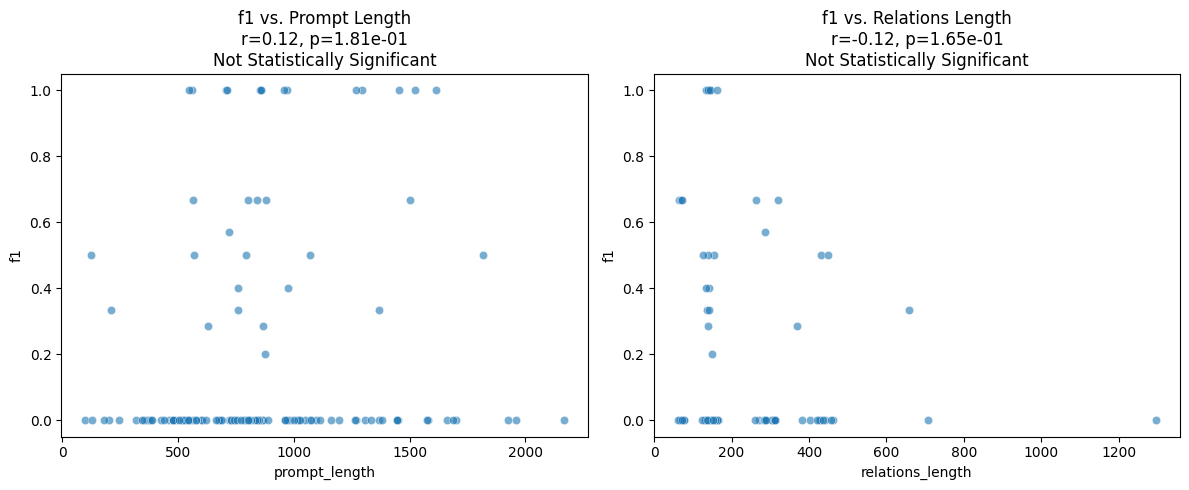

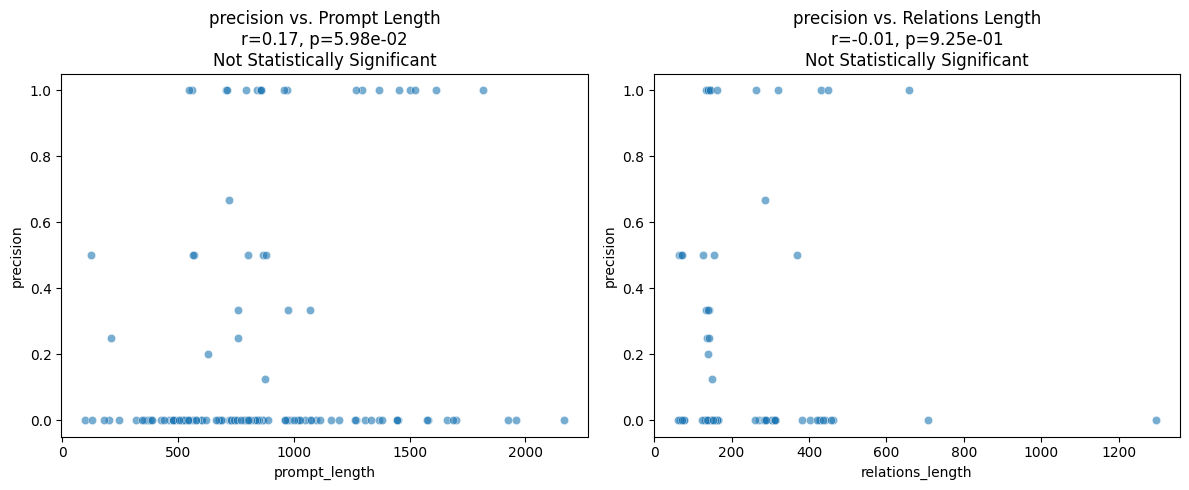

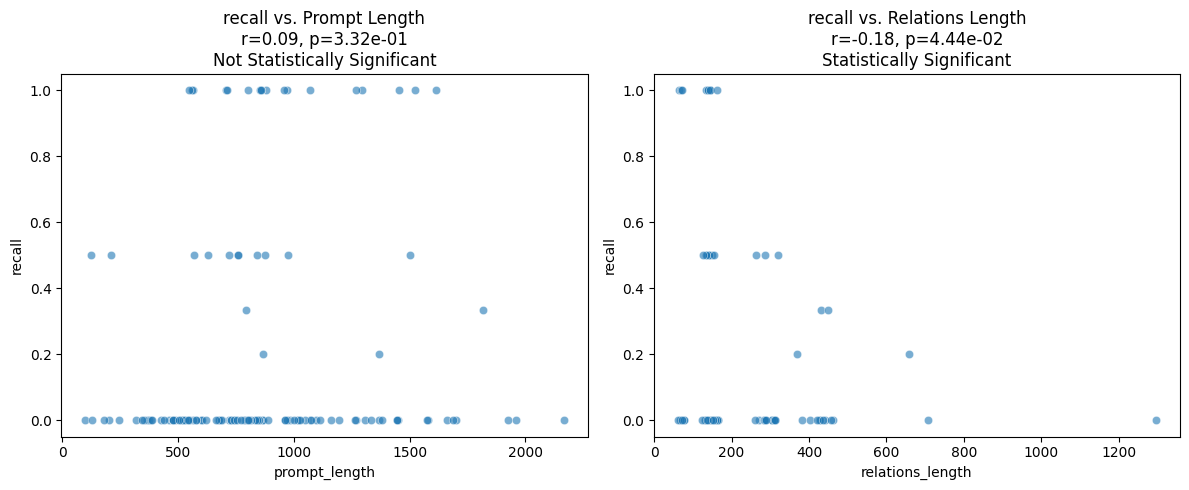

In [326]:
# Compute the metrics correlation with length
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Assuming your dataframe is named df
# Calculate the length of relations for each row
df['relations_length'] = df['true_relations'].apply(lambda x: sum([len(str(relation)) for relation in x]))

# Plotting correlation between prompt length and metrics
metrics = ['f1', 'precision', 'recall']

for metric in metrics:
    plt.figure(figsize=(12, 5))
    
    # Plot for prompt length
    plt.subplot(1, 2, 1)
    sns.scatterplot(data=df, x='prompt_length', y=metric, alpha=0.6)
    corr_coef, p_value = pearsonr(df['prompt_length'], df[metric])
    significance = "Statistically Significant" if p_value < 0.05 else "Not Statistically Significant"
    plt.title(f'{metric} vs. Prompt Length\nr={corr_coef:.2f}, p={p_value:.2e}\n{significance}')

    # Plot for relations length
    plt.subplot(1, 2, 2)
    sns.scatterplot(data=df, x='relations_length', y=metric, alpha=0.6)
    corr_coef, p_value = pearsonr(df['relations_length'], df[metric])
    significance = "Statistically Significant" if p_value < 0.05 else "Not Statistically Significant"
    plt.title(f'{metric} vs. Relations Length\nr={corr_coef:.2f}, p={p_value:.2e}\n{significance}')

    plt.tight_layout()
    plt.show()


In [330]:
import pandas as pd

# Sort the dataframe by 'f1'
df = df.sort_values('f1')
mask = df.prompt_length < 350
tmp = df[mask]

# Calculate the quartile boundaries
q3 = tmp['f1'].quantile(0.75)

# Select one example from each quartile
example_1 = tmp[df['f1'] <= 0].sample(1)
example_2 = tmp[(df['f1'] > 0) & (df['f1'] <= .45)].sample(1)
example_3 = tmp[(df['f1'] > .25)].sample(1)

# Concatenate the examples to get a dataframe of examples from each quartile
exemplary_samples = pd.concat([example_1, example_2, example_3, example_4])

exemplary_samples


/tmp/ipykernel_139176/2882830022.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  example_1 = tmp[df['f1'] <= 0].sample(1)
/tmp/ipykernel_139176/2882830022.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  example_2 = tmp[(df['f1'] > 0) & (df['f1'] <= .45)].sample(1)
/tmp/ipykernel_139176/2882830022.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  example_3 = tmp[(df['f1'] > .25)].sample(1)


,id,prompt,predicted_relations,true_relations,precision,recall,f1,prompt_length,relations_length
83,identity_226,"Speaker 1: So, thanks for having me over! Rach...","[{'x': 'Speaker 1', 'r': 'visitors', 'y': 'Phe...","[{'x': 'Speaker 1', 'r': 'visited_place', 'y':...",0.00,0.0,0.000000,246.0,152.0
58,identity_152,"Speaker 1: Kids, I spoke to a doctor and picke...","[{'x': 'Speaker 1', 'r': 'parents', 'y': 'Spea...","[{'x': 'Speaker 2', 'r': 'parents', 'y': 'Spea...",0.25,0.5,0.333333,212.0,143.0
115,identity_314,Speaker 1: The next station is Poughkeepsie. P...,"[{'x': 'Poughkeepsie', 'r': 'visited_place', '...","[{'x': 'Ross', 'r': 'visited_place', 'y': 'Pou...",0.50,0.5,0.500000,126.0,154.0
25,identity_64,"Speaker 1: So um, so what's up, you came to se...","[{'x': 'Speaker 1', 'r': 'spouse', 'y': 'Speak...","[{'x': 'Speaker 1', 'r': 'spouse', 'y': 'Speak...",1.00,1.0,1.000000,NaN,NaN


In [332]:
def format_relations(relations):
    formatted_relations = []
    for relation in relations:
        try:
            formatted_relations.append({
                "x": relation['x'],
                "x_type": "PERSON",  # Assuming all are persons, you can adjust based on your dataset
                "y": relation['y'],
                "y_type": "PERSON",  # Assuming all are persons, you can adjust based on your dataset
                "r": relation['r']
            })
        except KeyError as e:
            print(f"KeyError: {e}. Problematic relation: {relation}")
    return formatted_relations


def convert_to_new_format(sample, relations='predicted_relations'):
    dialog = []
    
    # Split prompt into sentences and format them
    for line in sample['prompt'].split("\n"):
        speaker, content = line.split(": ", 1)
        dialog.append(f"{speaker}: {content}")
    
    # Format relations
    formatted_relations = format_relations(sample[relations])
    
    return [dialog, formatted_relations]

# Loop through all samples and convert them to the desired format
all_formatted_data = [convert_to_new_format(row.to_dict(), 
                                            # relations='true_relations'
                                            ) for _, row in exemplary_samples.iterrows()]

json.dumps(all_formatted_data)


'[[["Speaker 1: So, thanks for having me over! Rach. Pheebs.", "Speaker 2: See ya!! What the hell was that?!", "Speaker 3: Probably some y\'know, European good-bye thing he picked up in London.", "Speaker 4: That\'s not European!", "Speaker 5: Well, it felt French."], [{"x": "Speaker 1", "x_type": "PERSON", "y": "Pheebs", "y_type": "PERSON", "r": "visitors"}, {"x": "Pheebs", "x_type": "PERSON", "y": "Speaker 1", "y_type": "PERSON", "r": "visitors"}]], [["Speaker 1: Kids, I spoke to a doctor and picked up this pamphlets on how to get pregnant.", "Speaker 2: Hey dad!", "Speaker 3: Hey.", "Speaker 1: Sorry to bother you again, but could you pass my pamphlets back? Thank you."], [{"x": "Speaker 1", "x_type": "PERSON", "y": "Speaker 2", "y_type": "PERSON", "r": "parents"}, {"x": "Speaker 1", "x_type": "PERSON", "y": "Speaker 3", "y_type": "PERSON", "r": "children"}, {"x": "Speaker 3", "x_type": "PERSON", "y": "Speaker 1", "y_type": "PERSON", "r": "parents"}, {"x": "Speaker 2", "x_type": "PE

<Axes: >

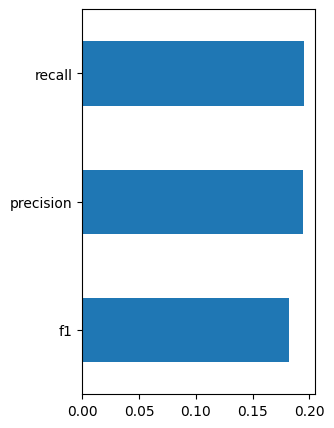

In [261]:
df[['precision', 'recall', 'f1']].mean().sort_values().plot(kind='barh', figsize=(3, 5))

<Axes: ylabel='Frequency'>

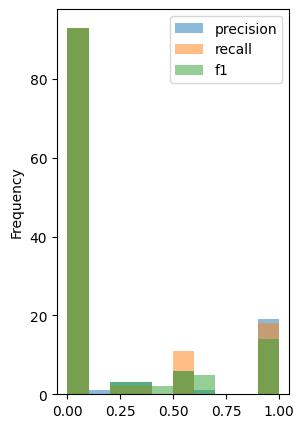

In [263]:
df[['precision', 'recall', 'f1']].plot(kind='hist', alpha=0.5, figsize=(3, 5))


In [222]:
df.predicted_relations.iloc[87]
# df.true_relations.iloc[87]

[OrderedDict([('x', 'Speaker 2'), ('r', 'visited_place'), ('y', 'Delaware')]),
 OrderedDict([('x', 'Delaware'),
              ('r', 'visitors_of_place'),
              ('y', 'Speaker 2')])]

<Axes: >

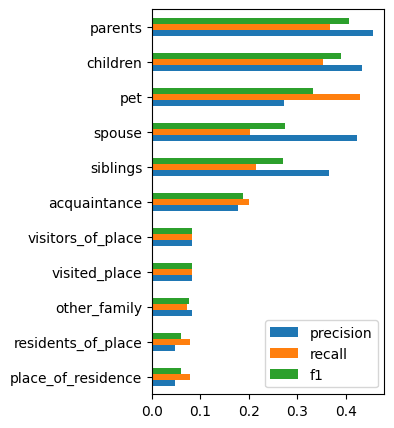

In [258]:
pd.DataFrame(results['per_class']).T.sort_values('f1', ascending=True).plot(kind='barh', figsize=(3, 5))

460

In [231]:
infer_from_model('Alice: Hi, you are my father.\nRobert: Yes, I am your father')

'[{"x": "Alice", "r": "parents", "y": "Robert"}, {"x": "Robert", "r": "children", "y": "Alice"}]'